# Preparation and Data Cleaning

Importing the data science packages required

In [1]:
import pandas as pd;
import numpy as np;
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import metrics

Reading and exploring data

In [2]:
data = pd.read_csv('videogame.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


There are ~17k games, but some of the data is missing. For instance, only around half of all games has a critic score. This might be a problem for the prediction model, as critic score can be one of the major factors determing the Global Sales. User_Score has non-numeric format. Most of the games have a pretty good score, 7+ (or 70+ for critic score)

In the next cell, I am doing 4 things:

- Renaming columns for ease of use
- Droping games without a year of release or genre
- Creating a new column for age of the game
- Converting User_Score to float and replacing the tbd value in dataset with *NA*

In [3]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)
data.describe(include="all")

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age
count,16448,16448,16448.000000,16448,16416,16448.000000,16448.000000,16448.000000,16448.000000,16448.00000,7983.000000,7983.000000,7463.000000,7463.000000,9907,9769,16448.000000
unique,11429,31,NaN,12,579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680,8,NaN
top,Need for Speed: Most Wanted,PS2,NaN,Action,Electronic Arts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ubisoft,E,NaN
freq,12,2127,NaN,3308,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,3922,NaN
mean,NaN,NaN,2006.488996,NaN,NaN,0.263965,0.145895,0.078472,0.047583,0.53617,68.994363,26.441313,7.126330,163.015141,NaN,NaN,11.511004
std,NaN,NaN,5.877470,NaN,NaN,0.818286,0.506660,0.311064,0.187984,1.55846,13.920060,19.008136,1.499447,563.863327,NaN,NaN,5.877470
min,NaN,NaN,1980.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.01000,13.000000,3.000000,0.000000,4.000000,NaN,NaN,-2.000000
25%,NaN,NaN,2003.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.06000,60.000000,12.000000,6.400000,10.000000,NaN,NaN,8.000000
50%,NaN,NaN,2007.000000,NaN,NaN,0.080000,0.020000,0.000000,0.010000,0.17000,71.000000,22.000000,7.500000,24.000000,NaN,NaN,11.000000
75%,NaN,NaN,2010.000000,NaN,NaN,0.240000,0.110000,0.040000,0.030000,0.47000,79.000000,36.000000,8.200000,81.000000,NaN,NaN,15.000000


From, the output above, we can see: -
- There are high outliers in sales columns (NA, EU, JP, Other, Global) and User_Count column.

They might be usefull for training as they indicate bestseller games, but for now I am going to remove them and maybe add them later.
The below function can be used to remove outliers present in the data set. A data entry is called an outlier if: - 
- value < Q1 - 3 * IQR
- value > Q3 + 3 * IQR

where,
- Q1 - First Quartile
- Q3 - Thrid Quartile
- IQR - Inter-quartile range

In [4]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) |
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
        
    return df_out, removed

In [5]:
data, rmvd_global = rm_outliers(data, ["Global"])
data.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,7286.000000,7286.000000,6747.000000,6747.000000,15401.000000
mean,2006.592624,0.144688,0.072628,0.047301,0.024357,0.289258,67.779028,24.518117,7.079976,111.325033,11.407376
std,5.758078,0.210709,0.131408,0.130786,0.050152,0.346918,13.612120,17.194878,1.511031,406.635191,5.758078
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000,-2.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,59.000000,11.000000,6.300000,9.000000,8.000000
50%,2007.000000,0.070000,0.020000,0.000000,0.010000,0.150000,70.000000,20.000000,7.400000,21.000000,11.000000
75%,2010.000000,0.190000,0.080000,0.030000,0.030000,0.380000,78.000000,34.000000,8.200000,61.000000,15.000000
max,2020.000000,1.670000,1.580000,1.650000,1.180000,1.690000,98.000000,106.000000,9.700000,10665.000000,38.000000


There are nearly half of the games which do not have scores. In ideal cases, you would like to drop these colunmns. But dropping over 8000+ entries is not possible in our case as it will heavily affect the models.
Therefore, I am going to build 2 models: a basic one and an advanced model. In a basic model I will drop games without a score (critic or user) and train it on the remaining data. I will also do minimum feature engineering or feature selection. 

After I am finished with the basic model, I am going to come back to the full dataset and try to impute missing values and create new features.

# Basic Model

In [6]:
# Making a new column which shows if the game is scored or not. (User score and Critic Score)

data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()
rmvd_global["Has_Score"] = rmvd_global["User_Score"].notnull() & rmvd_global["Critic_Score"].notnull()

For my basic model I am going to drop games that don't have a user score, critic score or rating. I will also remove outliers in User_Count column. Only 5.5k games, ~1/3 of all games in a dataset remaining after doing the above steps.

In [7]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored, rmvd_user_count = rm_outliers(scored, ["User_Count"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000
mean,2007.055837,0.205403,0.098572,0.028995,0.036368,0.369597,67.815866,24.958439,7.124575,37.459523,10.944163
std,4.010373,0.225580,0.138941,0.095492,0.056428,0.367824,13.408831,15.689528,1.440391,44.572477,4.010373
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000
25%,2004.000000,0.060000,0.010000,0.000000,0.010000,0.100000,60.000000,13.000000,6.400000,9.000000,8.000000
50%,2007.000000,0.130000,0.040000,0.000000,0.020000,0.230000,70.000000,22.000000,7.400000,20.000000,11.000000
75%,2010.000000,0.280000,0.130000,0.000000,0.047500,0.520000,78.000000,34.000000,8.200000,45.000000,14.000000
max,2016.000000,1.670000,1.160000,1.390000,1.130000,1.690000,98.000000,91.000000,9.600000,233.000000,33.000000


In [8]:
scored["Platform"].unique(), scored["Genre"].unique(), scored["Rating"].unique()
# 17 unique platfoms, 12 unique genres and 5 ratings are present in the given data.

(array(['PS2', 'GBA', 'X360', 'PS3', 'PC', 'Wii', 'PSP', 'PS', 'XB', 'GC',
        'DS', 'XOne', '3DS', 'DC', 'PS4', 'WiiU', 'PSV'], dtype=object),
 array(['Shooter', 'Action', 'Role-Playing', 'Racing', 'Simulation',
        'Sports', 'Fighting', 'Platform', 'Misc', 'Strategy', 'Puzzle',
        'Adventure'], dtype=object),
 array(['M', 'E', 'T', 'E10+', 'RP'], dtype=object))

There are 17 unique platfoms, 12 unique genres and 5 ratings in the remaining data. In the advanced model I will try grouping platforms to reduce amount, but for now I will just one-hot encode them. 

Feaures will consist of numeric columns (except for sales in regions and year - using age instead) and one-hot encoded categorical columns (platform, genre, rating).

In [9]:
import category_encoders as ce

# Numeric columns
numeric_subset = scored.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encoding
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Column binding to the previos numeric dataset
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

Let's look at the highest and lowest correlations with the global sales column.

In [10]:
correlations.head()

# Platform 5 = PC
# Genre 10 = Strategy
# Genre 12 = Adventure
# Platform 17 = PSV
# Platform 15 = PS4

Platform_5    -0.186725
Genre_10      -0.094686
Genre_12      -0.084227
Platform_17   -0.069683
Platform_15   -0.062370
Name: Global, dtype: float64

In [11]:
correlations.tail()

User_Score      0.155470
User_Count      0.252651
Critic_Score    0.281545
Critic_Count    0.292327
Global          1.000000
Name: Global, dtype: float64

Splitting data into training set (80%) and test set (20%)

In [12]:
from sklearn.model_selection import train_test_split

X = features.drop(columns="Global")
Y = pd.Series(features["Global"])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,random_state=42)

print(X_train.shape)

(4427, 42)


In the next 2 cells I have: - 
- Defining function for mean absolute error
- Defining function for fitting the model

In [13]:
def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))

In [14]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(Y_test, model_pred)
    
    # Return the performance metric
    return model_mae

I will compare several simple models with different types of regression, and then focus on the best one for hyperparameter tuning.

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [16]:
baseline_guess = np.median(X_train)
basic_baseline_mae = mae(X_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(basic_baseline_mae))

Baseline guess for global sales is: 0.00
Baseline Performance on the test set: MAE = 3.6713


In [17]:
# Linear Regression
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print("Linear Regression Performance on the test set: MAE = {:.04f}".format(lr_mae))

Linear Regression Performance on the test set: MAE = 0.2361


In [18]:
svm = SVR(C = 1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm)

print("Support Vector Machine Regression Performance on the test set: MAE = {:.04f}".format(svm_mae))

Support Vector Machine Regression Performance on the test set: MAE = 0.2859


In [19]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set: MAE = {:.04f}".format(random_forest_mae))

c:\users\suran\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set: MAE = 0.2317


In [20]:
gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae = fit_and_evaluate(gradient_boosting)

print("Gradient Boosting Regression Performance on the test set: MAE = {:.04f}".format(gradient_boosting_mae))

Gradient Boosting Regression Performance on the test set: MAE = 0.2197


In [21]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set: MAE = {:.04f}".format(knn_mae))

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.2556


In [22]:
ridge = Ridge(alpha=10)
ridge_mae = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set: MAE = {:.04f}".format(ridge_mae))

Ridge Regression Performance on the test set: MAE = 0.2354


In [23]:
MLP = MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
MLP_mae = fit_and_evaluate(MLP)

print("MLP Regression Performance on the test set: MAE = {:.04f}".format(MLP_mae))

MLP Regression Performance on the test set: MAE = 0.2259


In [24]:
lasso = Lasso()
lasso_mae = fit_and_evaluate(lasso)

print("Lasso Regression Performance on the test set: MAE = {:.04f}".format(lasso_mae))

Lasso Regression Performance on the test set: MAE = 0.2811


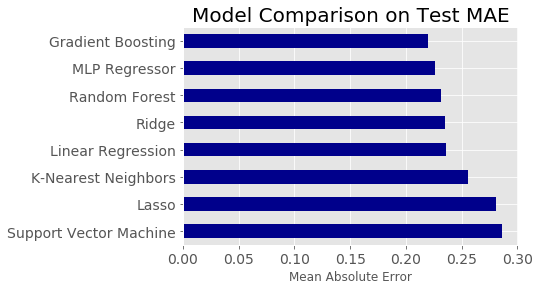

In [25]:
style.use('ggplot')
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Support Vector Machine","Random Forest", "Gradient Boosting",
                                            "K-Nearest Neighbors", "Ridge", "MLP Regressor", "Lasso"],
                                 "mae": [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosting_mae, knn_mae, ridge_mae, MLP_mae, lasso_mae]})

model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh",
                                                           color="darkblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test MAE", size=20);

# Gradient Boosting is the best out of the 5 models chosen

Gradient boosting regressor seems to be the best model, I will focus on this one.

First I am going to use randomized search to find the best parameters, and then I will use grid search for optimizing n_estimators.

In [26]:
hyperparameter_grid = {"loss": ["ls", "lad", "huber"],
                       "max_depth": [2, 3, 5, 10, 15],
                       "min_samples_leaf": [1, 2, 4, 6, 8],
                       "min_samples_split": [2, 4, 6, 10],
                       "max_features": ["auto", "sqrt", "log2", None]}

In [27]:
from sklearn.model_selection import RandomizedSearchCV

basic_model = GradientBoostingRegressor(random_state = 42)
random_cv = RandomizedSearchCV(estimator=basic_model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)

In [28]:
random_cv.fit(X_train, Y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   32.9s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Printing out 10 best estimators found by randomized search.


In [29]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values("mean_test_score", ascending=False)
random_results.head(10)[["mean_test_score", "param_loss",
                         "param_max_depth", "param_min_samples_leaf", "param_min_samples_split",
                         "param_max_features"]]

,mean_test_score,param_loss,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features
0,-0.200249,huber,15,8,6,log2
17,-0.200575,lad,15,2,4,log2
7,-0.202390,huber,5,6,6,auto
16,-0.208902,lad,3,1,10,log2
15,-0.208946,ls,5,4,6,auto
8,-0.210783,lad,2,4,10,auto
19,-0.214095,lad,2,1,10,sqrt
3,-0.214285,lad,2,8,10,sqrt
1,-0.214556,huber,2,2,4,None
2,-0.217556,ls,3,1,4,sqrt


In [30]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Using grid search to find optimal value of the n_estimators parameter.

In [31]:
# Using grid search to find optimal value of the n_estimators parameter.
from sklearn.model_selection import GridSearchCV
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

basic_model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=basic_model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)

In [32]:
grid_search.fit(X_train, Y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   16.4s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min...       subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [33]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=50,
             n_iter_no_change=None, presort='auto', random_state=42,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [34]:
grid_search.fit(X_train, Y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   16.3s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min...       subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

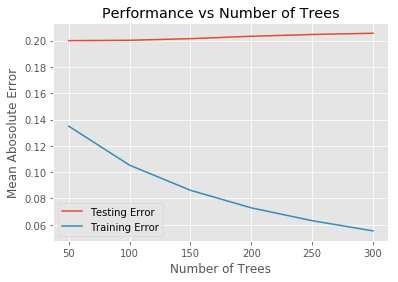

In [35]:
results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Testing Error")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Training Error")
plt.xlabel("Number of Trees"); plt.ylabel("Mean Abosolute Error"); plt.legend();
plt.title("Performance vs Number of Trees");

The graph shows that the model is overfitting. Training error keeps decreasing, while test error stays almost the same. It means that the model learns training examples very well, but cannot generalize on new, unknown data. This is not a very good model and try to battle overfitting in the advanced model using imputing, feature selection and feature engineering.

Let's lock the final model and see how it performs on test data.

In [36]:
basic_final_model = grid_search.best_estimator_
basic_final_pred = basic_final_model.predict(X_test)
basic_final_mae = mae(Y_test, basic_final_pred)
print("Final model performance on the test set: MAE = {:.04f}.".format(basic_final_mae))

Final model performance on the test set: MAE = 0.2095.


MAE dropped, but by a very small margin. Looks like hyperparameter tuning didn't really improve the model. I hope advanced model will have a better performance. To finish with the basic model I am going to draw 2 graphs. First one is comparison of densities of train values, test values and predictions.

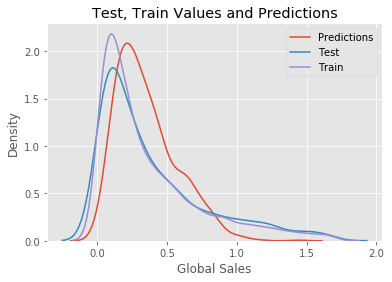

In [37]:
# Density plots for predictions ,test, train

sns.kdeplot(basic_final_pred, label = "Predictions")
sns.kdeplot(Y_test, label = "Test")
sns.kdeplot(Y_train, label = "Train")

plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");

Predictions density is moved a little to the right, comparing to densities of initial values. The tail is also different. This might help tuning the model in the future.

Second graph is a histogram of residuals - differences between real values and predictions.

Text(0.5, 1.0, 'Distribution of Residuals')

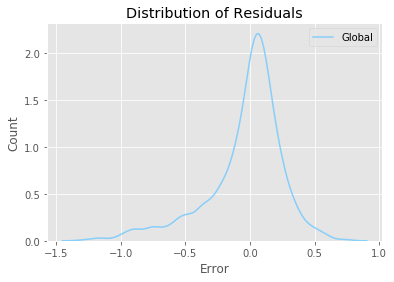

In [38]:
# Residuals plot

basic_residuals = basic_final_pred - Y_test

sns.kdeplot(basic_residuals, color = "lightskyblue")
plt.xlabel("Error"); plt.ylabel("Count")
plt.title("Distribution of Residuals")

# Advanced Model

In [39]:
#Number of unique platforms present 
data["Platform"].unique()

array(['Wii', 'PS2', 'PS3', 'PS', 'N64', 'GBA', 'DS', 'GC', 'X360', 'GB',
       'PC', '3DS', 'PSP', 'XB', 'NES', 'PS4', 'GEN', '2600', 'SNES',
       'XOne', 'WiiU', 'PSV', 'SCD', 'DC', 'SAT', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

There are too many different platforms and most of them represent a very small percent of games. I am going to group platforms to reduce the number of features.

In [40]:
#Grouping platforms together
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

Below are the functions that I am going to use to plot the data and get inferences as well help to group the platforms as required.

In [41]:
def visual_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

In [42]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

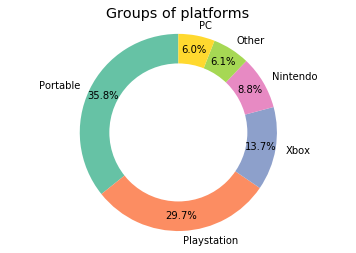

In [43]:
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
visual_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");

Looks much better.

Now I want to check the same thing for genres.

(-1.111416724196605,
 1.1029715226410872,
 -1.1036933723428801,
 1.1001758748734705)

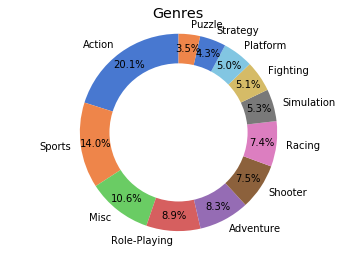

In [44]:
visual_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal")

The distribution seems ok, even though there is a significant number of different genres.

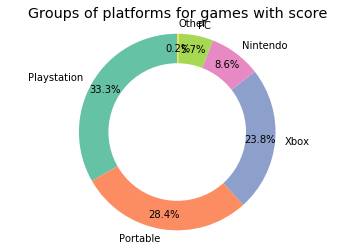

In [45]:
#Grouping the platforms for the entries whose score is given
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, platforms))
visual_chart(scored["Grouped_Platform"])
plt.title("Groups of platforms for games with score")
plt.axis("equal");

Almost all games that have scores are for "big" platfroms: PC, PS, Xbox or portable. But there are few from the "Other" group. Below are the results what the "Other" platform represents. (DC - Dreamcast)

In [46]:
scored[scored["Grouped_Platform"]=="Other"]

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age,Has_Score,Grouped_Platform
1712,Shenmue,DC,1999,Adventure,Sega,0.52,0.24,0.38,0.04,1.18,88.0,9.0,9.4,201.0,Sega AM2,T,19,True,Other
1877,NFL 2K1,DC,2000,Sports,Sega,1.02,0.05,0.00,0.02,1.09,97.0,22.0,6.0,47.0,Visual Concepts,E,18,True,Other
3815,Seaman,DC,1999,Simulation,Sega,0.00,0.00,0.52,0.00,0.52,82.0,24.0,8.4,16.0,Vivarium,T,19,True,Other
5350,SoulCalibur,DC,1999,Fighting,Namco Bandai Games,0.00,0.00,0.34,0.00,0.34,98.0,24.0,8.8,200.0,Namco,T,19,True,Other
7231,Capcom vs. SNK,DC,2000,Fighting,Virgin Interactive,0.00,0.00,0.22,0.00,0.22,80.0,17.0,9.0,24.0,Capcom,T,18,True,Other
7521,Phantasy Star Online,DC,2000,Role-Playing,Sega,0.00,0.00,0.20,0.00,0.20,89.0,21.0,9.1,33.0,Sonic Team,T,18,True,Other
7643,Grandia II,DC,2000,Role-Playing,Ubisoft,0.00,0.00,0.20,0.00,0.20,90.0,17.0,8.8,57.0,Game Arts,T,18,True,Other
7978,Phantasy Star Online Ver. 2,DC,2001,Role-Playing,Sega,0.00,0.00,0.19,0.00,0.19,80.0,10.0,8.9,18.0,Sonic Team,T,17,True,Other
8905,Shenmue II,DC,2001,Adventure,Sega,0.00,0.00,0.15,0.00,0.15,88.0,9.0,9.4,201.0,Sega AM2,T,17,True,Other
9559,Sega GT,DC,2000,Racing,Sega,0.00,0.00,0.13,0.00,0.13,84.0,25.0,7.7,11.0,TOSE,E,18,True,Other


Next I want to create some new features: weighted score and my own developer rating. First, I find percent of all games created by each developer, then calculate cumulative percent starting with devs with the least number of games. Finally, I divide them into 5 groups (20% each). Higher rank means more games developed. 

Higher top percentage means more games developed.

In [47]:
# One weighted score value including all scores and counts field.
scored["Weighted_Score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])

# Dataframe having developers arranged based on their frequency 
devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})

# Mean scoring datafram based on the weighted score
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Weighted_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Weighted_Score"].mean().values})

# Creating merging the mean_score and developer dataframes and then sorting the resultant into ascending order
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)

# Percentage of all games created by each developer and storing it in form of cumulative fashion
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100

# Dividing them into 10 groups
n_groups = 10
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

c:\users\suran\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,dev,count,mean_score,percent,top%,top_group
1179,WBIE,1,72.259459,0.000181,0.018070,1.0
842,"Zoe Mode, HB Studios Multimedia",1,42.911111,0.000181,0.036140,1.0
843,Rhino Studios,1,62.260870,0.000181,0.054210,1.0
844,SEK Ost,1,76.307692,0.000181,0.072280,1.0
845,"Tecmo, Graphic Research",1,88.642857,0.000181,0.090351,1.0
846,The Workshop,1,71.568807,0.000181,0.108421,1.0
847,Red Zone Entertainment,1,49.913043,0.000181,0.126491,1.0
848,Magic Rings,1,78.714286,0.000181,0.144561,1.0
849,Atomic Games,1,58.654545,0.000181,0.162631,1.0
850,"Machatin, Inc.",1,64.840000,0.000181,0.180701,1.0


Before creating and fitting a model I have to fill in missing values. I am filling scores and counts with zeros, because there were no real zero scores or counts in the dataset, so it will indicate absence of scores. 

In [48]:
data["Critic_Score"].fillna(0.0, inplace=True)
data["Critic_Count"].fillna(0.0, inplace=True)
data["User_Score"].fillna(0.0, inplace=True)
data["User_Count"].fillna(0.0, inplace=True)
data = data.join(devs.set_index("dev")["top_group"], on="Developer")
data = data.rename(columns={"top_group": "Developer_Rank"})
data["Developer_Rank"].fillna(0.0, inplace=True)
data["Rating"].fillna("None", inplace=True)


Removing outliers in User_Count columns.

In [49]:
tmp, rmvd_tmp = rm_outliers(data[data["User_Count"] != 0], ["User_Count"])
data.drop(rmvd_tmp.index, axis=0, inplace=True)

Creating Weighted_Score column (earlier I did it for "scored" dataframe).

In [50]:
data["Weighted_Score"] = (data["User_Score"] * 10 * data["User_Count"] + 
                            data["Critic_Score"] * data["Critic_Count"]) / (data["User_Count"] + data["Critic_Count"])
data["Weighted_Score"].fillna(0.0, inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14743 entries, 1058 to 16718
Data columns (total 21 columns):
Name                14743 non-null object
Platform            14743 non-null object
Year                14743 non-null int64
Genre               14743 non-null object
Publisher           14712 non-null object
NA                  14743 non-null float64
EU                  14743 non-null float64
JP                  14743 non-null float64
Other               14743 non-null float64
Global              14743 non-null float64
Critic_Score        14743 non-null float64
Critic_Count        14743 non-null float64
User_Score          14743 non-null float64
User_Count          14743 non-null float64
Developer           8519 non-null object
Rating              14743 non-null object
Age                 14743 non-null int64
Has_Score           14743 non-null bool
Grouped_Platform    14743 non-null object
Developer_Rank      14743 non-null float64
Weighted_Score      14743 non-null float64


Now I will do the same things as I did in the basic model, except for using Ordinal encoding for categorical values instead of OneHot.

In [52]:
# Select the numeric columns
numeric_subset = data.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical columns
categorical_subset = data[["Grouped_Platform", "Genre", "Rating"]]

mapping = []
for cat in categorical_subset.columns:
    tmp = scored.groupby(cat).median()["Weighted_Score"]
    mapping.append({"col": cat, "mapping": [x for x in np.argsort(tmp).items()]})
    
encoder = ce.ordinal.OrdinalEncoder()
categorical_subset = encoder.fit_transform(categorical_subset, mapping=mapping)

# Join the two dataframes using concat. Axis = 1 -> Column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

In [53]:
features

,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age,Developer_Rank,Weighted_Score,Grouped_Platform,Genre,Rating
1058,1.69,0.0,0.0,7.8,4.0,9,6.0,78.000000,1,1,1
1059,1.69,82.0,59.0,8.8,64.0,13,3.0,85.121951,2,2,2
1061,1.69,0.0,0.0,0.0,0.0,19,0.0,0.000000,2,3,3
1062,1.69,0.0,0.0,0.0,0.0,3,0.0,0.000000,2,2,3
1063,1.69,0.0,0.0,0.0,0.0,21,0.0,0.000000,3,4,3
1064,1.69,0.0,0.0,0.0,0.0,20,0.0,0.000000,2,4,3
1065,1.69,64.0,8.0,7.1,7.0,17,8.0,67.266667,4,5,4
1066,1.69,53.0,15.0,6.9,28.0,16,4.0,63.418605,4,6,4
1067,1.69,0.0,0.0,0.0,0.0,9,0.0,0.000000,4,7,3
1069,1.69,63.0,11.0,0.0,0.0,11,2.0,63.000000,4,8,4


Dividing the final data into training and testing. After that I applyied the gradient boosting algorithm and then fitting the respective hyperparameters by using randomized search to do so.

In [54]:
target = pd.Series(features["Global"])
features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2,
                                                                            random_state=42)

In [55]:
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)
random_cv.fit(features_train, target_train);

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   59.3s finished


In [56]:
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)
grid_search.fit(features_train, target_train);

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.3min finished


In [57]:
# Getting the final model error 
final_model = grid_search.best_estimator_
final_pred = final_model.predict(features_test)
final_mae = mae(target_test, final_pred)
print("Final model performance on the test set: MAE = {:.04f}.".format(final_mae))

Final model performance on the test set: MAE = 0.1757.


"Advanced" model gives better results (lower error on test set) which is a good achievement. There is definitely room for improvement. And to finish with the project, a nice group of plots summarizing the results.

Text(0.5, 1.0, 'Test MAE')

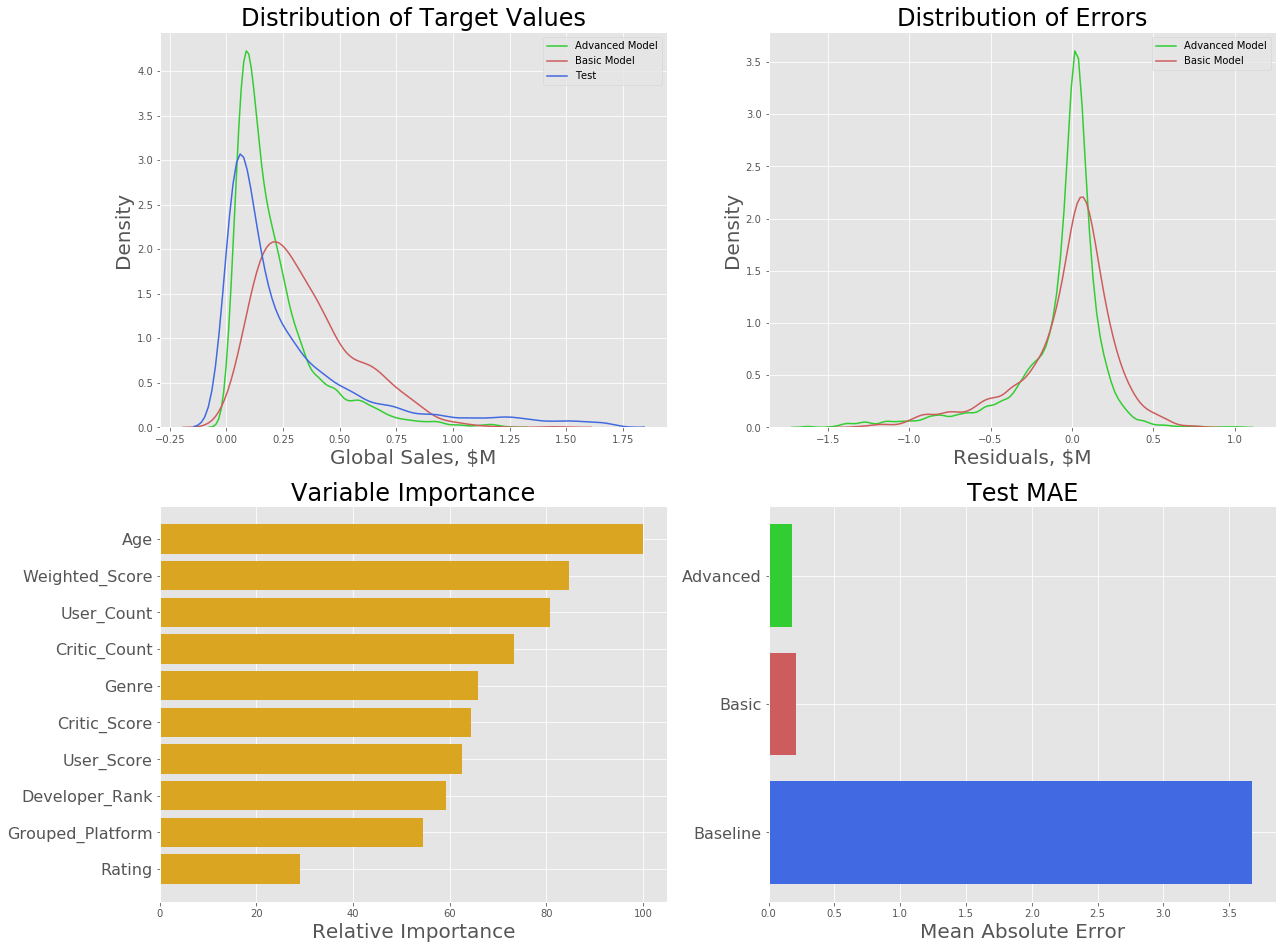

In [58]:
# Final Comparison Graph

plt.figure(figsize=(20, 16))
plt.title("Video Games - Predicting Global Sales", size=30, weight="bold");

ax=plt.subplot(2, 2, 1)
sns.kdeplot(final_pred, color="limegreen", label="Advanced Model")
sns.kdeplot(basic_final_pred, color="indianred", label="Basic Model")
sns.kdeplot(target_test, color="royalblue", label="Test")
plt.xlabel("Global Sales, $M", size=20)
plt.ylabel("Density", size=20)
plt.title("Distribution of Target Values", size=24)

residuals = final_pred - target_test
ax =plt.subplot(2, 2, 2)
sns.kdeplot(residuals, color = "limegreen", label="Advanced Model")
sns.kdeplot(basic_residuals, color="indianred", label="Basic Model")
plt.xlabel("Residuals, $M", size=20)
plt.ylabel("Density", size=20);
plt.title("Distribution of Errors", size=24)

feature_importance = final_model.feature_importances_
feature_names = features.columns.tolist()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
ax =plt.subplot(2, 2, 3)
plt.barh(pos, feature_importance[sorted_idx], align='center', color="goldenrod")
plt.yticks(pos, [feature_names[x] for x in sorted_idx], size=16)
plt.xlabel('Relative Importance', size=20)
plt.title('Variable Importance', size=24)

model_comparison = pd.DataFrame({"model": ["Baseline", "Basic", "Advanced"],
                                 "mae": [basic_baseline_mae, basic_final_mae, final_mae],
                                 "color": ["royalblue", "indianred", "limegreen"]})
model_comparison.sort_values("mae", ascending=False)
pos = np.arange(3) + .5
ax =plt.subplot(2, 2, 4)
plt.barh(pos, model_comparison["mae"], align="center", color=model_comparison["color"])
plt.yticks(pos, model_comparison["model"], size=16); plt.xlabel("Mean Absolute Error", size=20);
plt.title("Test MAE", size=24)